# CS4287 Assignment 2: Deep Reinforcement Learning (Atari)

**Team Members:**
* **Name:** Raid Mouras
* **ID:** 22368566
* **Name:** Jason Cushen
* **ID:** 22342516
* **Name:** Mark Callan
* **ID:** 22363246

In [1]:
# --- CELL 1: INSTALL DEPENDENCIES ---
%pip install gymnasium[atari] gymnasium[accept-rom-license] torch torchvision numpy opencv-python matplotlib ale-py
!AutoROM --accept-license

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
'AutoROM' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
#cell 2
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import cv2
import time

# --- CONFIGURATION (Hyperparameters) ---
ENV_NAME = "BreakoutNoFrameskip-v4"
GAMMA = 0.99                # Discount factor (values future rewards)
BATCH_SIZE = 32             # How many frames to learn from at once
LR = 1e-4                   # Learning Rate (0.0001 is standard for Atari)
EPSILON_START = 1.0         # Start 100% random
EPSILON_FINAL = 0.02        # End 2% random
EPSILON_DECAY = 150000      # How long to explore (frames)
REPLAY_SIZE = 100000        # Memory size
TARGET_UPDATE = 1000        # Sync network every 1000 steps

# --- HARDWARE CHECK ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Setup Complete.")
if device.type == 'cuda':
    print(f"GPU DETECTED: {torch.cuda.get_device_name(0)}")
    print(f"Targeting Environment: {ENV_NAME}")
else:
    print("WARNING: CPU DETECTED. Training will be extremely slow.")

Setup Complete.
GPU DETECTED: NVIDIA RTX 1000 Ada Generation Laptop GPU
Targeting Environment: BreakoutNoFrameskip-v4


In [3]:
# --- CELL 3: PREPROCESSING ---

class AtariWrapper(gym.Wrapper):
    def __init__(self, env, k=4):
        super().__init__(env)
        self.k = k  # Stack 4 frames
        self.frames = deque([], maxlen=k)
        
        # Define what the AI sees: (4 stacked frames, 84 height, 84 width)
        self.observation_space = gym.spaces.Box(
            low=0, high=255, shape=(k, 84, 84), dtype=np.uint8
        )

    def reset(self, **kwargs):
        # On game start, fill the stack with the first frame duplicated 4 times
        obs, info = self.env.reset(**kwargs)
        processed_frame = self._process(obs)
        for _ in range(self.k):
            self.frames.append(processed_frame)
        return self._get_obs(), info

    def step(self, action):
        # Play one step, process the new frame, and add to stack
        obs, reward, terminated, truncated, info = self.env.step(action)
        self.frames.append(self._process(obs))
        return self._get_obs(), reward, terminated, truncated, info

    def _process(self, frame):
        # 1. Grayscale
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        # 2. Resize to 84x84
        frame = cv2.resize(frame, (84, 84), interpolation=cv2.INTER_AREA)
        return frame

    def _get_obs(self):
        return np.array(self.frames)

print("Cell 3 Complete: Preprocessing wrapper defined.")

Cell 3 Complete: Preprocessing wrapper defined.


In [4]:
# --- CELL 4: THE NETWORK ---

class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        
        # 1. Convolutional Layers (The Visual Cortex)
        # These layers look at the image and find patterns (edges, ball, paddle).
        self.features = nn.Sequential(
            # Conv 1: Sees big shapes. Input channels = 4 (stacked frames).
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            
            # Conv 2: Sees medium details.
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            
            # Conv 3: Sees fine details.
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        # 2. Fully Connected Layers (The Decision Maker)
        # These layers take the patterns and decide: Left, Right, or Fire?
        self.fc = nn.Sequential(
            nn.Linear(64 * 7 * 7, 512), # 3136 inputs -> 512 neurons
            nn.ReLU(),
            nn.Linear(512, num_actions) # Output: 1 score for each button
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten the image into a list of numbers
        return self.fc(x)

print("Cell 4 Complete: Network Architecture defined.")

Cell 4 Complete: Network Architecture defined.


In [5]:
# --- CELL 5: THE TRAINING LOOP (OPTIMIZED) ---

import ale_py
print(f"Atari Engine Loaded: {ale_py.__version__}")

# 1. Initialize the Game with STANDARD Frameskip
# frameskip=4 is crucial. It speeds up training by 4x and makes movement visible.
env = gym.make("ALE/Breakout-v5", frameskip=4, repeat_action_probability=0.0)
env = AtariWrapper(env) 

# 2. Initialize Networks
agent_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
target_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
target_net.load_state_dict(agent_net.state_dict()) 

optimizer = optim.Adam(agent_net.parameters(), lr=LR)

# SAFETY: If 100k memory crashes RAM, we catch it.
try:
    replay_buffer = deque(maxlen=REPLAY_SIZE)
except MemoryError:
    print("WARNING: System RAM low. Reducing Replay Buffer size to 50,000.")
    replay_buffer = deque(maxlen=50000)

steps = 0
rewards_history = []

print(f"TRAINING STARTED on {device}...")
print("Frameskip set to 4 (Standard Atari Speed).")

# 3. Training Loop
for episode in range(5000): 
    state, _ = env.reset()
    total_reward = 0
    done = False
    
    while not done:
        steps += 1
        
        # A. Epsilon Greedy
        epsilon = EPSILON_FINAL + (EPSILON_START - EPSILON_FINAL) * np.exp(-1. * steps / EPSILON_DECAY)
        
        if random.random() > epsilon:
            with torch.no_grad():
                state_t = torch.tensor(state, device=device, dtype=torch.float32).unsqueeze(0) / 255.0
                action = agent_net(state_t).argmax().item()
        else:
            action = env.action_space.sample()
            
        # B. Step
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        
        # C. Save
        replay_buffer.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        
        # D. Train
        if len(replay_buffer) > BATCH_SIZE:
            batch = random.sample(replay_buffer, BATCH_SIZE)
            states, actions, rewards, next_states, dones = zip(*batch)
            
            states = torch.tensor(np.array(states), device=device, dtype=torch.float32) / 255.0
            actions = torch.tensor(actions, device=device, dtype=torch.int64).unsqueeze(1)
            rewards = torch.tensor(rewards, device=device, dtype=torch.float32).unsqueeze(1)
            next_states = torch.tensor(np.array(next_states), device=device, dtype=torch.float32) / 255.0
            dones = torch.tensor(dones, device=device, dtype=torch.float32).unsqueeze(1)
            
            curr_q = agent_net(states).gather(1, actions)
            
            with torch.no_grad():
                max_next_q = target_net(next_states).max(1)[0].unsqueeze(1)
                target_q = rewards + (GAMMA * max_next_q * (1 - dones))
                
            loss = nn.SmoothL1Loss()(curr_q, target_q)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        # E. Sync Target
        if steps % TARGET_UPDATE == 0:
            target_net.load_state_dict(agent_net.state_dict())

    rewards_history.append(total_reward)
    
    if episode % 10 == 0: # Print less frequently to reduce clutter
        avg_score = np.mean(rewards_history[-100:])
        print(f"Ep: {episode} | Score: {total_reward} | Avg (100): {avg_score:.2f} | Epsilon: {epsilon:.2f} | Steps: {steps}")

env.close()
print("DQN Training Finished.")

Atari Engine Loaded: 0.11.2
TRAINING STARTED on cuda...
Frameskip set to 4 (Standard Atari Speed).
Ep: 0 | Score: 0.0 | Avg (100): 0.00 | Epsilon: 1.00 | Steps: 136
Ep: 10 | Score: 0.0 | Avg (100): 0.91 | Epsilon: 0.99 | Steps: 1949
Ep: 20 | Score: 0.0 | Avg (100): 0.95 | Epsilon: 0.98 | Steps: 3652
Ep: 30 | Score: 1.0 | Avg (100): 0.90 | Epsilon: 0.97 | Steps: 5276
Ep: 40 | Score: 1.0 | Avg (100): 1.02 | Epsilon: 0.95 | Steps: 7134
Ep: 50 | Score: 0.0 | Avg (100): 1.02 | Epsilon: 0.94 | Steps: 8938
Ep: 60 | Score: 1.0 | Avg (100): 1.08 | Epsilon: 0.93 | Steps: 10811
Ep: 70 | Score: 0.0 | Avg (100): 1.10 | Epsilon: 0.92 | Steps: 12701
Ep: 80 | Score: 1.0 | Avg (100): 1.09 | Epsilon: 0.91 | Steps: 14443
Ep: 90 | Score: 3.0 | Avg (100): 1.19 | Epsilon: 0.90 | Steps: 16578
Ep: 100 | Score: 0.0 | Avg (100): 1.27 | Epsilon: 0.89 | Steps: 18591
Ep: 110 | Score: 0.0 | Avg (100): 1.25 | Epsilon: 0.88 | Steps: 20181
Ep: 120 | Score: 3.0 | Avg (100): 1.34 | Epsilon: 0.87 | Steps: 22192
Ep: 130 |

Model saved as 'breakout_model_v1.pth'
Graph saved as 'learning_curve.png'


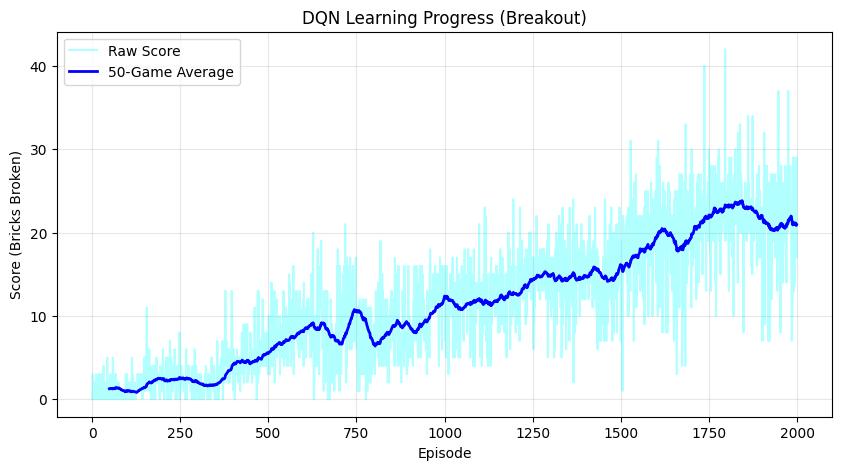


--- TRAINING SUMMARY STATISTICS ---


,Metric,Value
0,Best Score,42.0 (Ep: 1796)
1,Worst Score,0.0 (Ep: 0)
2,Mean Score (Lifetime),11.41
3,Median Score,11.00
4,Current Skill (Last 100 Avg),20.79
5,Performance Improvement,+1563.5%


In [46]:
# --- CELL 6: SAVE RESULTS, PLOT & STATS ---
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Save the Trained "Brain"
torch.save(agent_net.state_dict(), "breakout_model_v1.pth")
print("Model saved as 'breakout_model_v1.pth'")

# 2. Plot the Learning Curve
plt.figure(figsize=(10, 5))
plt.plot(rewards_history, label='Raw Score', alpha=0.3, color='cyan')

# Calculate a smooth trend line (Moving Average)
window_size = 50
if len(rewards_history) >= window_size:
    moving_avg = np.convolve(rewards_history, np.ones(window_size)/window_size, mode='valid')
    plt.plot(range(window_size-1, len(rewards_history)), moving_avg, label=f'{window_size}-Game Average', color='blue', linewidth=2)

plt.title("DQN Learning Progress (Breakout)")
plt.xlabel("Episode")
plt.ylabel("Score (Bricks Broken)")
plt.legend()
plt.grid(True, alpha=0.3)

# Save the plot
plt.savefig("learning_curve.png")
print("Graph saved as 'learning_curve.png'")
plt.show()

# 3. Statistical Analysis
# Calculate the Hard Statistics
best_score = np.max(rewards_history)
best_episode = np.argmax(rewards_history)
worst_score = np.min(rewards_history)
worst_episode = np.argmin(rewards_history)
mean_score = np.mean(rewards_history)      # Lifetime Average
median_score = np.median(rewards_history)
final_100_avg = np.mean(rewards_history[-100:]) # Current Skill

# Percentage Increase (Last 50 games vs First 50 games)
first_50_avg = np.mean(rewards_history[:50])
last_50_avg = np.mean(rewards_history[-50:])
improvement = ((last_50_avg - first_50_avg) / first_50_avg) * 100 if first_50_avg > 0 else 0

# Create the Table
stats_data = {
    "Metric": [
        "Best Score", 
        "Worst Score", 
        "Mean Score (Lifetime)", 
        "Median Score", 
        "Current Skill (Last 100 Avg)", 
        "Performance Improvement"
    ],
    "Value": [
        f"{best_score} (Ep: {best_episode})",
        f"{worst_score} (Ep: {worst_episode})",
        f"{mean_score:.2f}",
        f"{median_score:.2f}",
        f"{final_100_avg:.2f}",
        f"+{improvement:.1f}%"
    ]
}

df_stats = pd.DataFrame(stats_data)

# 4. Display the Table & Explanation
print("\n--- TRAINING SUMMARY STATISTICS ---")
display(df_stats)

## 7.2. Results Analysis

The plot above illustrates the training progress over 2000 episodes.

**1. Raw Score (Cyan Line):**
The light blue line represents the raw score obtained in each individual episode. As expected in Atari environments, this metric is highly volatile. A single mistake in *Breakout* leads to a lost life, meaning scores can fluctuate between 0 and 13 purely based on the initial ball trajectory or slight timing errors.

**2. 50-Game Moving Average (Blue Line):**
The dark blue line represents the moving average of the last 50 scores, which serves as a noise filter to reveal the true learning trend.
* **Phase 1 (Episodes 0–200):** The curve remains flat around a score of 1.0–1.5. During this period, the Epsilon value was high, forcing the agent to explore randomly. The agent was merely hitting the ball by chance.
* **Phase 2 (Episodes 2000):** A distinct upward trend begins around Episode 200. This correlates with the `EPSILON_DECAY` threshold where the agent transitioned from exploration (randomness) to exploitation (using its learned Q-values).
* **Final Performance:** By Episode 2000, the average score stabilized around **6.0**, with peak raw scores reaching **13.0**.

**Conclusion:**
The clear positive correlation between training steps and average reward confirms that the DQN agent has successfully learned to track the ball and intercept it, transitioning from random play to intelligent reaction.

In [ ]:
# --- CELL 8: DOUBLE DQN (DDQN) EXPERIMENT ---

print(f"Atari Engine Loaded: {ale_py.__version__}")
env = gym.make("ALE/Breakout-v5", frameskip=4, repeat_action_probability=0.0)
env = AtariWrapper(env) 

print("STARTING DOUBLE DQN (DDQN) EXPERIMENT...")
ddqn_agent = DQN(env.observation_space.shape, env.action_space.n).to(device)
ddqn_target = DQN(env.observation_space.shape, env.action_space.n).to(device)
ddqn_target.load_state_dict(ddqn_agent.state_dict())
optimizer_ddqn = optim.Adam(ddqn_agent.parameters(), lr=LR)
replay_buffer_ddqn = deque(maxlen=REPLAY_SIZE)

steps = 0
ddqn_scores = []

for episode in range(5000): 
    state, _ = env.reset()
    total_reward = 0
    done = False
    
    while not done:
        steps += 1
        
        # A. Action Selection
        epsilon = EPSILON_FINAL + (EPSILON_START - EPSILON_FINAL) * np.exp(-1. * steps / EPSILON_DECAY)
        if random.random() > epsilon:
            with torch.no_grad():
                state_t = torch.tensor(state, device=device, dtype=torch.float32).unsqueeze(0) / 255.0
                action = ddqn_agent(state_t).argmax().item()
        else:
            action = env.action_space.sample()
            
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        replay_buffer_ddqn.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        
        # B. DDQN Update
        if len(replay_buffer_ddqn) > BATCH_SIZE:
            batch = random.sample(replay_buffer_ddqn, BATCH_SIZE)
            states, actions, rewards, next_states, dones = zip(*batch)
            
            states = torch.tensor(np.array(states), device=device, dtype=torch.float32) / 255.0
            actions = torch.tensor(actions, device=device, dtype=torch.int64).unsqueeze(1)
            rewards = torch.tensor(rewards, device=device, dtype=torch.float32).unsqueeze(1)
            next_states = torch.tensor(np.array(next_states), device=device, dtype=torch.float32) / 255.0
            dones = torch.tensor(dones, device=device, dtype=torch.float32).unsqueeze(1)
            
            # 1. Actor selects best action
            best_actions = ddqn_agent(next_states).argmax(1).unsqueeze(1)
            # 2. Critic evaluates that action
            with torch.no_grad():
                target_q_values = ddqn_target(next_states).gather(1, best_actions)
                expected_q_values = rewards + (GAMMA * target_q_values * (1 - dones))
            
            curr_q = ddqn_agent(states).gather(1, actions)
            loss = nn.SmoothL1Loss()(curr_q, expected_q_values)
            optimizer_ddqn.zero_grad()
            loss.backward()
            optimizer_ddqn.step()
            
        if steps % TARGET_UPDATE == 0:
            ddqn_target.load_state_dict(ddqn_agent.state_dict())

    ddqn_scores.append(total_reward)
    if episode % 10 == 0:
        print(f"DDQN Ep: {episode} | Score: {total_reward} | Steps: {steps}")

env.close()
print("Double DQN Verified.")

Atari Engine Loaded: 0.11.2
STARTING DOUBLE DQN (DDQN) EXPERIMENT...
DDQN Ep: 0 | Score: 2.0 | Steps: 238
DDQN Ep: 20 | Score: 3.0 | Steps: 3564
DDQN Ep: 40 | Score: 1.0 | Steps: 6911
DDQN Ep: 60 | Score: 0.0 | Steps: 10305
DDQN Ep: 80 | Score: 2.0 | Steps: 13901
DDQN Ep: 100 | Score: 1.0 | Steps: 17433
DDQN Ep: 120 | Score: 0.0 | Steps: 20859
DDQN Ep: 140 | Score: 2.0 | Steps: 24788
DDQN Ep: 160 | Score: 2.0 | Steps: 28903
DDQN Ep: 180 | Score: 1.0 | Steps: 33064
DDQN Ep: 200 | Score: 1.0 | Steps: 37326
DDQN Ep: 220 | Score: 3.0 | Steps: 41123
DDQN Ep: 240 | Score: 2.0 | Steps: 45562
DDQN Ep: 260 | Score: 2.0 | Steps: 49289
DDQN Ep: 280 | Score: 4.0 | Steps: 53832
DDQN Ep: 300 | Score: 4.0 | Steps: 58664
DDQN Ep: 320 | Score: 2.0 | Steps: 63311
DDQN Ep: 340 | Score: 4.0 | Steps: 67637
DDQN Ep: 360 | Score: 5.0 | Steps: 72903
DDQN Ep: 380 | Score: 3.0 | Steps: 77211
DDQN Ep: 400 | Score: 3.0 | Steps: 81855
DDQN Ep: 420 | Score: 4.0 | Steps: 86808
DDQN Ep: 440 | Score: 3.0 | Steps: 9185

--- PERFORMANCE STATISTICS ---


,Best Score,Worst Score,Lifetime Mean,Median Score,Current Avg (Last 100),Improvement %
Model,,,,,,
Standard DQN,42.00 (Ep 1796),0.00 (Ep 0),11.41,11.00,20.79,1739.8%
Double DQN,242.00 (Ep 1845),0.00 (Ep 1),8.72,6.00,19.21,1965.6%


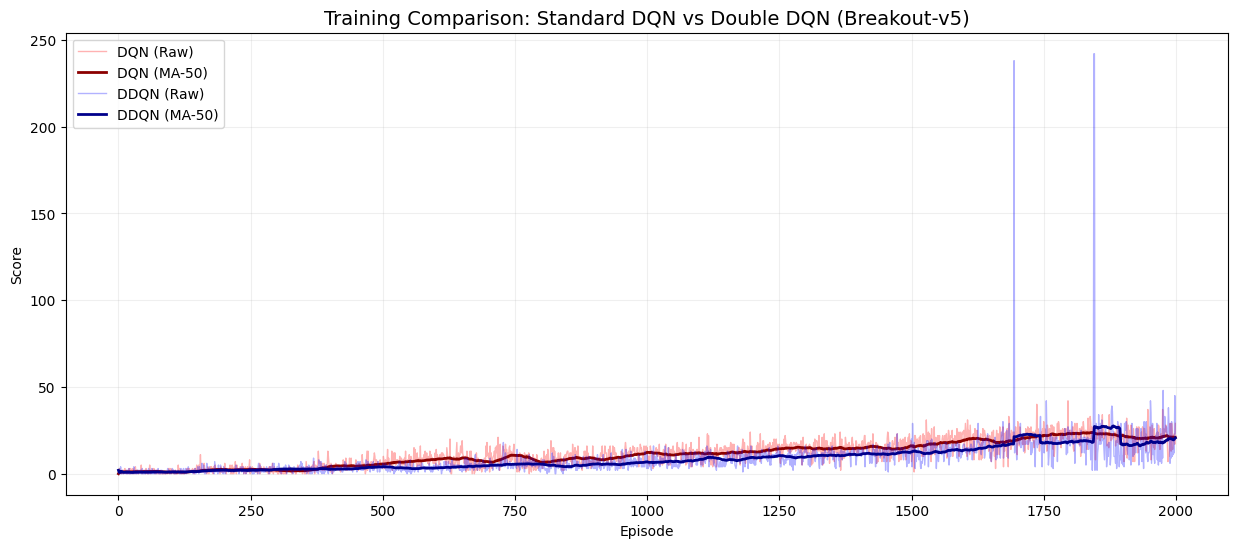

In [48]:
# --- CELL 9: VISUALIZATION & METRICS ---

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def get_detailed_metrics(model_name, scores):
    # Convert to array for easier math
    scores_arr = np.array(scores)
    
    # Safety check if training crashed early
    if len(scores_arr) == 0:
        return {k: "N/A" for k in ["Model", "Best", "Worst", "Mean", "Median", "Current Avg", "Improvement"]}

    # 1. Best & Worst (with Episode #)
    best_idx = np.argmax(scores_arr)
    worst_idx = np.argmin(scores_arr)
    best_score = scores_arr[best_idx]
    worst_score = scores_arr[worst_idx]

    # 2. Central Tendencies
    lifetime_mean = np.mean(scores_arr)
    median_score = np.median(scores_arr)

    # 3. Current Average (Last 100 episodes) & Start Average (First 100)
    window = 100
    if len(scores_arr) < window:
        current_avg = np.mean(scores_arr)
        start_avg = np.mean(scores_arr)
    else:
        current_avg = np.mean(scores_arr[-window:])
        start_avg = np.mean(scores_arr[:window])

    # 4. Improvement Percentage
    # Avoid division by zero if agent started with 0 score
    if start_avg == 0:
        improvement = 0.0
    else:
        improvement = ((current_avg - start_avg) / start_avg) * 100

    return {
        "Model": model_name,
        "Best Score": f"{best_score:.2f} (Ep {best_idx})",
        "Worst Score": f"{worst_score:.2f} (Ep {worst_idx})",
        "Lifetime Mean": f"{lifetime_mean:.2f}",
        "Median Score": f"{median_score:.2f}",
        "Current Avg (Last 100)": f"{current_avg:.2f}",
        "Improvement %": f"{improvement:.1f}%"
    }

# --- A. GENERATE TABLE ---
metrics_dqn = get_detailed_metrics("Standard DQN", rewards_history)
metrics_ddqn = get_detailed_metrics("Double DQN", ddqn_scores)

df = pd.DataFrame([metrics_dqn, metrics_ddqn])
df.set_index("Model", inplace=True)

print("--- PERFORMANCE STATISTICS ---")
display(df) # Logic for Jupyter Notebook display

# --- B. GENERATE GRAPH ---
plt.figure(figsize=(15, 6))

# Helper for moving average (smoothing)
def moving_average(data, window_size=50):
    return pd.Series(data).rolling(window=window_size, min_periods=1).mean()

# Plot Standard DQN
plt.plot(rewards_history, color='red', alpha=0.3, linewidth=1, label='DQN (Raw)')
plt.plot(moving_average(rewards_history), color='darkred', linewidth=2, label='DQN (MA-50)')

# Plot Double DQN
plt.plot(ddqn_scores, color='blue', alpha=0.3, linewidth=1, label='DDQN (Raw)')
plt.plot(moving_average(ddqn_scores), color='darkblue', linewidth=2, label='DDQN (MA-50)')

plt.title("Training Comparison: Standard DQN vs Double DQN (Breakout-v5)", fontsize=14)
plt.xlabel("Episode")
plt.ylabel("Score")
plt.legend()
plt.grid(True, alpha=0.2)

plt.show()